## Open notebook in:
| Colab                                  Gradient                                                                        
:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/transformers-the-definitive-guide/blob/master/CH02/ch02_Chronos.ipynb)                                             

#About this notebook


This notebook provides an overview how you can use [`Chronos`](https://arxiv.org/abs/2403.07815) for time series forecasting  the `Chronos` model. The workflow includes setting up the environment, loading data, generating forecasts, and evaluating model performance.

### Steps Included:

1. **Setup and Installation**:  
   The necessary libraries and the `Chronos` repository are cloned and installed, along with other dependencies required for the forecasting pipeline.

2. **Loading Pre-trained Model**:  
   The `ChronosPipeline` is initialized with a pre-trained `Chronos-T5` model.

3. **Data Preparation**:  
   Time series data, such as air passenger numbers or Amazon stock prices, is loaded and preprocessed. The data is split into training and test sets based on a specified prediction length. The training data is then converted to a PyTorch tensor for compatibility with the model.

4. **Forecast Generation**:  
   Using the pre-trained `Chronos` model, forecasts are generated for the specified prediction length. The results include median forecasts along with confidence intervals, providing a range of possible future values.

5. **Data Conversion to Arrow Format**:  
   To efficiently handle large time series datasets, the data is converted to Arrow format, which is optimized for performance and storage. This format is used for training and evaluating the model.

6. **Model Evaluation and Saving**:  
   After generating forecasts, the model's performance is evaluated by comparing predicted and actual values. The fine-tuned model is then pushed to the Hugging Face Hub for future use, making it accessible for further predictions.

7. **Loading and Evaluating Fine-Tuned Model**:  
   The fine-tuned model is reloaded from the Hugging Face Hub, and its predictions are evaluated on the test dataset. The results are visualized, showcasing the accuracy of the predictions over the test period.

_Note:_ The performance of the model will degrade, since I fine-tuned it in July 2024. You would have to fine-tune it again on your data, you can leverage the code from my linked repo for that.


In [ ]:
!pip install -q git+https://github.com/amazon-science/chronos-forecasting.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/Nicolepcx/chronos-forecasting.git

Cloning into 'chronos-forecasting'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 274 (delta 110), reused 86 (delta 61), pack-reused 114 (from 1)
Receiving objects: 100% (274/274), 829.20 KiB | 26.75 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
%cd chronos-forecasting

/content/chronos-forecasting


In [ ]:
!pip install -r requirements.txt -qqq
!pip  install huggingface_hub -qqq
!pip install pyarrow -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

# Imports

In [ ]:
import os
import sys
from pathlib import Path
from typing import List, Optional, Union
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyarrow as pa
import pyarrow.parquet as pq
import yfinance as yf

from gluonts.dataset.arrow import ArrowWriter
from chronos import ChronosPipeline

# Add chronos to the system path
chronos_path = Path('/content/chronos-forecasting/src')
sys.path.append(str(chronos_path))

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

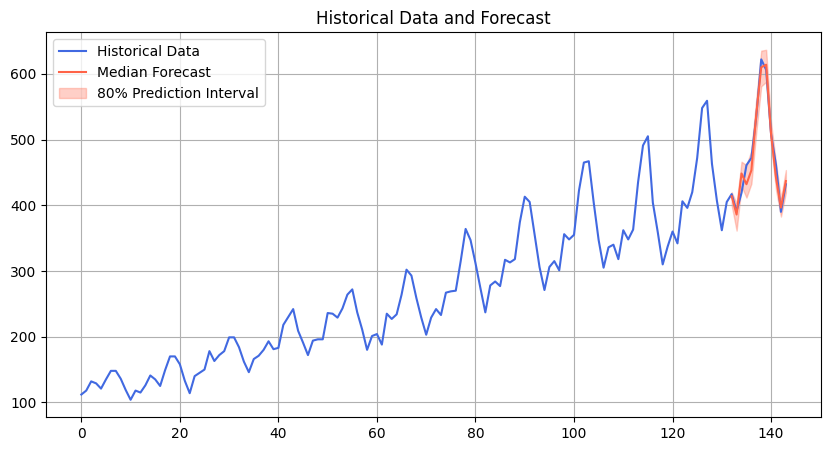

In [ ]:
# Load the model
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-base",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# Define the prediction length
prediction_length = 12

# Split the data into training and test sets
split_index = len(df) - prediction_length
train_data = df["#Passengers"][:split_index]
test_data = df["#Passengers"][split_index:]

# Convert the training data to a tensor
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(train_data.values)

# Generate the forecast
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# Get forecast quantiles
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Create the forecast index

forecast_index = range(len(train_data), len(train_data) + prediction_length)

# Plot the historical data and the forecast separately
plt.figure(figsize=(10, 5))

# Plot historical data
plt.plot(df["#Passengers"], color="royalblue", label="Historical Data")

plt.plot(forecast_index, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.legend()
plt.grid()
plt.title("Historical Data and Forecast")
plt.show()


In [ ]:

# Step 1: Download Amazon stock price data from yfinance
ticker = 'AMZN'
stock_data = yf.download(ticker, start='2000-01-01', end=datetime.today().strftime('%Y-%m-%d'))

# Preprocess the data
# Resample to daily frequency and fill missing values
stock_data = stock_data.resample('D').ffill()
time_series = stock_data['Close'].values
start_time = stock_data.index[0]

# Split into train and test sets
split_ratio = 0.8
split_index = int(len(time_series) * split_ratio)

train_time_series = time_series[:split_index]
test_time_series = time_series[split_index:]

train_start_time = start_time
test_start_time = stock_data.index[split_index]

# Convert the DataFrame into Arrow format for Chronos
def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    start_times: Optional[Union[List[np.datetime64], np.ndarray]] = None,
    compression: str = "lz4",
):
    assert len(time_series) == len(start_times)

    dataset = [
        {"start": start, "target": ts} for ts, start in zip(time_series, start_times)
    ]
    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )

# Prepare the training and test datasets
train_time_series_list = [train_time_series]
test_time_series_list = [test_time_series]

train_start_times = [train_start_time]
test_start_times = [test_start_time]

# Convert the time series data to Arrow format
convert_to_arrow("./amazon_train_data.arrow", time_series=train_time_series_list, start_times=train_start_times)
convert_to_arrow("./amazon_test_data.arrow", time_series=test_time_series_list, start_times=test_start_times)

# Check if the files are created
print("Training Arrow file created:", os.path.exists("./amazon_train_data.arrow"))
print("Test Arrow file created:", os.path.exists("./amazon_test_data.arrow"))


[*********************100%%**********************]  1 of 1 completed

Training Arrow file created: True
Test Arrow file created: True


#Evaluate Model

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

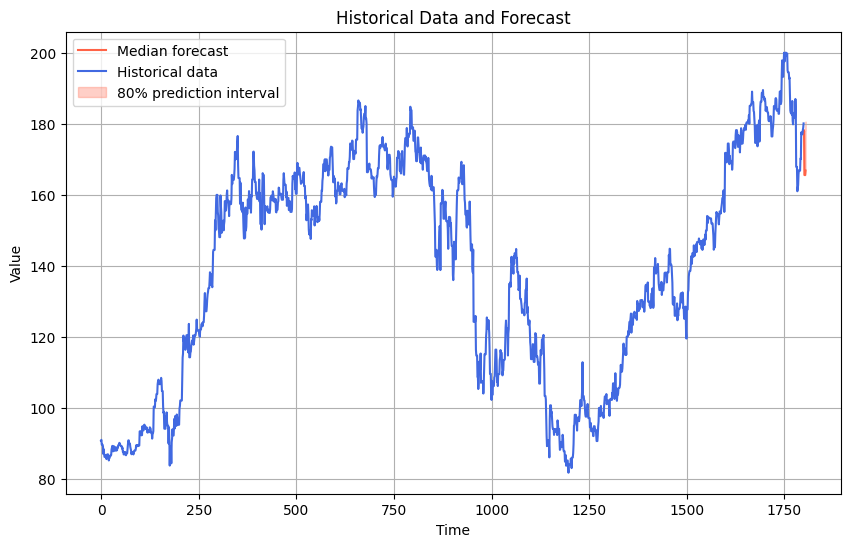

In [ ]:


# Set your Hugging Face token
#os.environ["HF_TOKEN"] = "your_token"

# Load the fine-tuned model from the Hugging Face Hub
pipeline = ChronosPipeline.from_pretrained(
    "nicolepcx/chronos-t5-base-fine-tuned-AMZN-EOD",
    use_auth_token=os.getenv("HF_TOKEN"),
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

# Load the test data from the Arrow file
arrow_path = "/content/chronos-forecasting/amazon_test_data.arrow"
table = pa.ipc.open_file(arrow_path).read_all()
df = table.to_pandas()

# Use the whole dataset for testing
all_forecasts = []
for idx, row in df.iterrows():
    context = torch.tensor(row['target'])
    prediction_length = 5
    forecast = pipeline.predict(context, prediction_length)
    all_forecasts.append(forecast[0].numpy())

# Plot the results for a selected series
selected_idx = 0
context = torch.tensor(df['target'].iloc[selected_idx])
forecast = all_forecasts[selected_idx]

forecast_index = range(len(context), len(context) + prediction_length)
low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(10, 6))

plt.plot(forecast_index, median, color="tomato", label="Median forecast")
plt.plot(context.numpy(), color="royalblue", label="Historical data")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.legend()
plt.grid()
plt.title("Historical Data and Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()
